In [22]:
# Import dependencies
import findspark
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark_dist_explore import hist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
# Initialize findspark
findspark.init()

# Initialize the spark session
spark = SparkSession.builder.appName("SK_model").getOrCreate()

In [3]:
# Load in the pre-processed data
s_df = spark.read.csv("../Resources/filtered_encoded_dataset.csv", sep=",", header=True, inferSchema=True)
s_df.show()

+-----------------+--------------------+----------+--------+------------+------+--------+----+-----------+------------+----------------+--------+-------+-------+------------------+----------------+----------------+----------------+----------------+----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|   primary_artist|          track_name|popularity|explicit|danceability|energy|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|      duration_min|time_signature_0|time_signature_1|time_signature_3|time_signature_4|time_signature_5|key_0|key_1|key_2|key_3|key_4|key_5|key_6|key_7|key_8|key_9|key_10|key_11|num_artists_binned_1|num_artists_binned_2|num_artists_binned_3|num_artists_binned_4|num_artists_b

In [4]:
# Remove primary_artist and track_name from the dataset
s_df = s_df.drop("primary_artist", "track_name")
s_df.show()

+----------+--------+------------+------+--------+----+-----------+------------+----------------+--------+-------+-------+------------------+----------------+----------------+----------------+----------------+----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|popularity|explicit|danceability|energy|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|      duration_min|time_signature_0|time_signature_1|time_signature_3|time_signature_4|time_signature_5|key_0|key_1|key_2|key_3|key_4|key_5|key_6|key_7|key_8|key_9|key_10|key_11|num_artists_binned_1|num_artists_binned_2|num_artists_binned_3|num_artists_binned_4|num_artists_binned_5|num_artists_binned_6|track_genre_0|track_genre_1|track_genre_2|track_g

(array([22457.,  9279., 18354., 14910., 19205., 14532.,  9344.,  4269.,
         1101.,    98.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 <BarContainer object of 10 artists>)

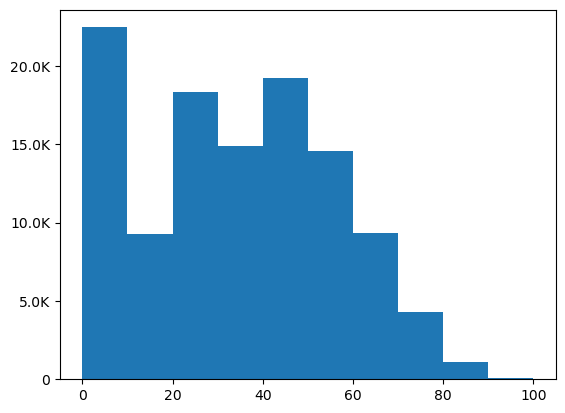

In [23]:
# Check popularity values
fig, ax = plt.subplots()
hist(ax, s_df.select("popularity"))

In [14]:
# Convert the data to a pandas Dataframe
df = s_df.toPandas()
df.head()

,popularity,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,num_artists_binned_4,num_artists_binned_5,num_artists_binned_6,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,track_genre_5,track_genre_6
0,73,0,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,0.3580,...,0,0,0,0,0,0,0,0,0,1
1,55,0,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,0.1010,...,0,0,0,0,0,0,0,0,0,1
2,57,0,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,0.1170,...,0,0,0,0,0,0,0,0,0,1
3,71,0,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,0.1320,...,0,0,0,0,0,0,0,0,0,1
4,82,0,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,0.0829,...,0,0,0,0,0,0,0,0,0,1


popularity
0      15843
1       2116
2       1025
3        570
4        377
       ...  
96         7
97         8
98         7
99         1
100        2
Name: count, Length: 101, dtype: int64

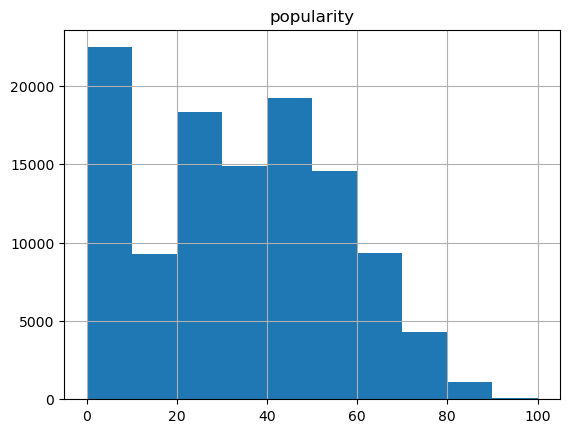

In [15]:
# Plot a histogram of popularity to determine ideal bins
df['popularity'].value_counts().sort_index()

In [16]:
## Bin the popularity into: 0, low=1 (0<pop<=30), medium=2 (30<pop<=60), high=3 (60<pop)
# Set up a list of bins
pop_bins = [0, 1, 2, 3]
# Set up list of conditions
pop_conditions = [
    (df["popularity"] == 0), 
    (df["popularity"] > 0) & (df["popularity"] <= 30),
    (df["popularity"] > 30) & (df["popularity"] <= 60),
    (df["popularity"] > 60)
]
# Set up the column with bins
df["popularity_binned"] = np.select(pop_conditions, pop_bins)

# Confirm binning
df['popularity_binned'].value_counts()

popularity_binned
2    48631
1    35514
0    15843
3    13561
Name: count, dtype: int64

In [17]:
# Remove the original popularity column
df.drop(columns="popularity", inplace=True)
# Check removal
df.head()

,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,num_artists_binned_5,num_artists_binned_6,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,track_genre_5,track_genre_6,popularity_binned
0,0,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,...,0,0,0,0,0,0,0,0,1,3
1,0,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,...,0,0,0,0,0,0,0,0,1,2
2,0,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,...,0,0,0,0,0,0,0,0,1,2
3,0,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,...,0,0,0,0,0,0,0,0,1,3
4,0,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,...,0,0,0,0,0,0,0,0,1,3


In [20]:
# Separate the prediction (song popularity) from the rest of the features
y = df.popularity_binned.values
X = df.drop(columns="popularity_binned")

# Split the training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)